In [1]:
#check for version of tensorflow

import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import os
import zipfile
import random
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop  #for compilation
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [3]:
#subset of the cats and dogs dataset 

!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-12-03 04:19:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  47.0MB/s    in 1.4s    

2020-12-03 04:19:41 (47.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
#unzip data

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
#define each directory
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

#see what files look like
print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.283.jpg', 'cat.88.jpg', 'cat.73.jpg', 'cat.933.jpg', 'cat.636.jpg', 'cat.558.jpg', 'cat.400.jpg', 'cat.360.jpg', 'cat.254.jpg', 'cat.540.jpg']
['dog.260.jpg', 'dog.511.jpg', 'dog.674.jpg', 'dog.816.jpg', 'dog.639.jpg', 'dog.761.jpg', 'dog.191.jpg', 'dog.980.jpg', 'dog.8.jpg', 'dog.934.jpg']


In [7]:
#find total number of cat and dog images in train and val

print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [8]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

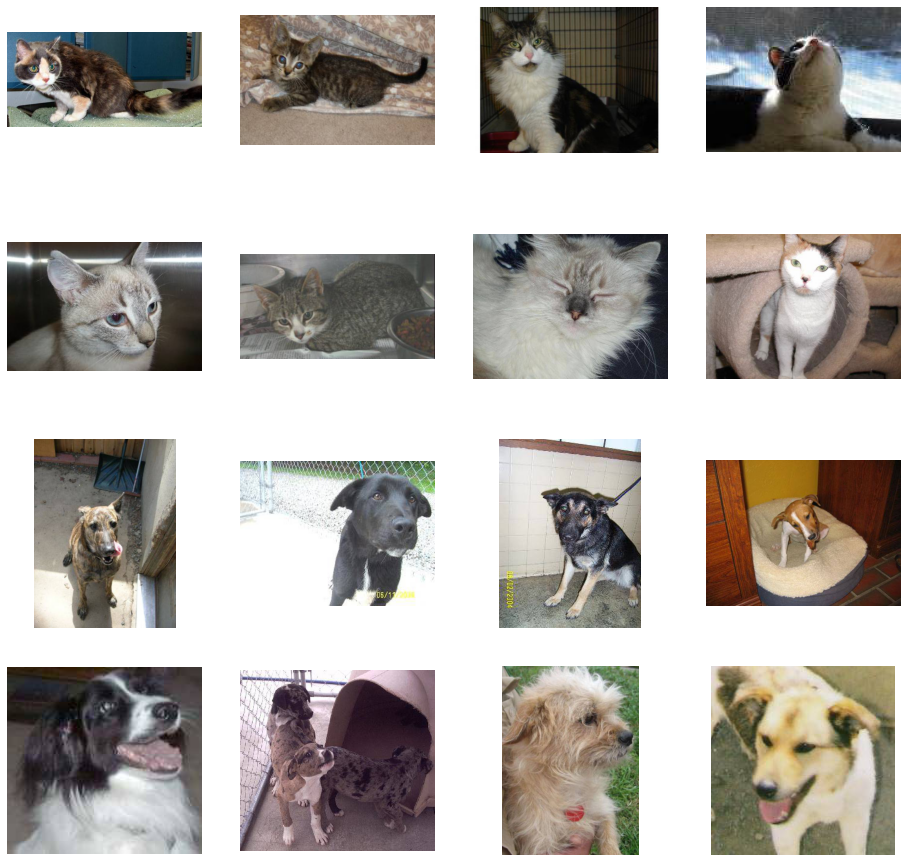

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [10]:
#create image generator

#normalize if needed
train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(
    #point at training directory
    train_dir,
    #specify target size               
    target_size=(150,150),   
    batch_size=20,
    #2 classes
    class_mode='binary'      
)

validation_generator = test_datagen.flow_from_directory(
    #point at training directory
    train_dir,
    #specify target size               
    target_size=(150,150),   
    batch_size=20,
    #2 classes
    class_mode='binary'      
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
#3 sets of convolutions followed by pooling, 1 sigmoid output

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                           input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               21234176  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [13]:
model.compile(loss='binary_crossentropy',
              #adjust lr parameter for learning rate
              optimizer=RMSprop(lr=0.001), 
              metrics=['accuracy'])

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Epoch 1/15
100/100 - 9s - loss: 1.1310 - accuracy: 0.5865 - val_loss: 0.5751 - val_accuracy: 0.7220
Epoch 2/15
100/100 - 8s - loss: 0.5823 - accuracy: 0.7060 - val_loss: 0.4122 - val_accuracy: 0.8500
Epoch 3/15
100/100 - 8s - loss: 0.4858 - accuracy: 0.7895 - val_loss: 0.3095 - val_accuracy: 0.9220
Epoch 4/15
100/100 - 9s - loss: 0.3551 - accuracy: 0.8620 - val_loss: 0.1749 - val_accuracy: 0.9510
Epoch 5/15
100/100 - 8s - loss: 0.2202 - accuracy: 0.9175 - val_loss: 0.0888 - val_accuracy: 0.9900
Epoch 6/15
100/100 - 8s - loss: 0.1581 - accuracy: 0.9590 - val_loss: 0.0513 - val_accuracy: 0.9900
Epoch 7/15
100/100 - 8s - loss: 0.1125 - accuracy: 0.9645 - val_loss: 0.0337 - val_accuracy: 0.9940
Epoch 8/15
100/100 - 8s - loss: 0.0541 - accuracy: 0.9845 - val_loss: 0.0193 - val_accuracy: 0.9950
Epoch 9/15
100/100 - 8s - loss: 0.0696 - accuracy: 0.9810 - val_loss: 0.0089 - val_accuracy: 0.9990
Epoch 10/15
100/100 - 8s - loss: 0.0847 - accuracy: 0.9770 - val_loss: 0.0055 - val_accuracy: 1.0000

Saving max_mil_portrait.jpg to max_mil_portrait (4).jpg
[0.]
max_mil_portrait.jpg is a cat


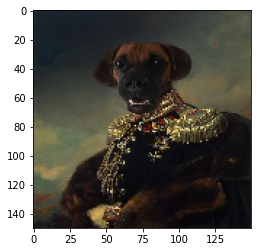

In [15]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")

plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


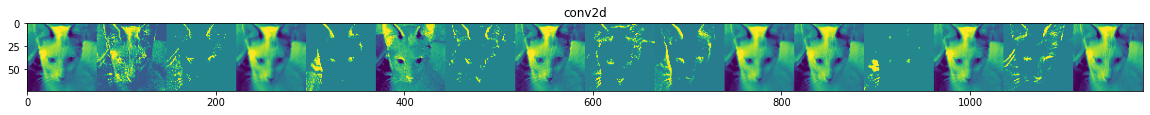

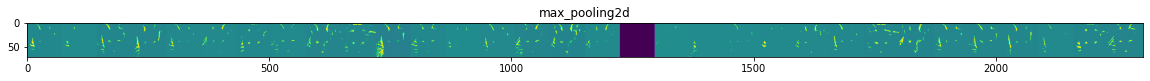

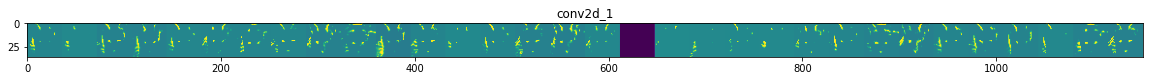

In [16]:
#define a new model that takes an image as input
#and outputs intermediate representations for all layers
#in the previous model after the first

successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

#random input image of cat or dog from training set
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150)) 

x   = img_to_array(img)                           # np array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # np array with shape (1, 150, 150, 3)

x /= 255.0

#run image through network to obtain all intermediate representations
successive_feature_maps = visualization_model.predict(x)

#include layer names in plot
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  #for conv/maxpool layers, not fully connected layers
  if len(feature_map.shape) == 4:
    
    n_features = feature_map.shape[-1]  # num features in feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # tile images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #postprocess for viewing
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x 

    #display grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

    #representations downstream highlight what the network pays attention to
    #fewer features are activated. This is representation sparsity

Text(0.5, 1.0, 'Training and validation loss')

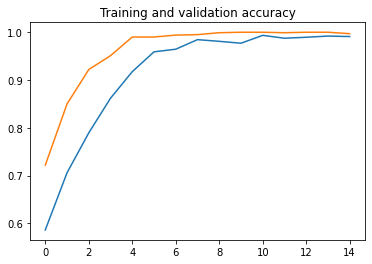

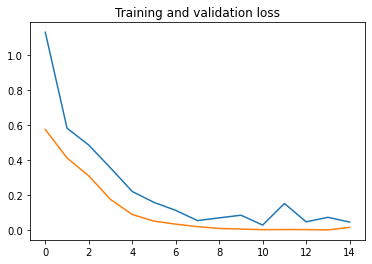

In [17]:
#list of results on train and test data for each epoch
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc))

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )